In [1]:
from zoish.feature_selectors.randomshap import RandomizedSearchCVShapFeatureSelector
import logging
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<Figure size 432x288 with 0 Axes>

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:
from zoish.utils.helper_funcs import RandomForestClassifier


grid_classification_xgb = RandomizedSearchCVShapFeatureSelector(
        # general argument setting        
        verbose=5,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=RandomForestClassifier(),
        estimator_params={
        "max_depth": [4, 5],
        "n_estimators": [50, 100],
        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=True,
        save_shap_summary_plot=False,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        n_iter = 10,
        ## optuna params
        performance_metric = 'f1',
        cv = StratifiedKFold(n_splits=3, shuffle=True),

)


<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_XGBCLS_OPTUNA', grid_classification_xgb),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ......max_depth=4, n_estimators=50;, score=0.597 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END ......max_depth=4, n_estimators=50;, score=0.609 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END ......max_depth=4, n_estimators=50;, score=0.615 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/3] END .....max_depth=4, n_estimators=100;, score=0.596 total time=   0.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END .....max_depth=4, n_estimators=100;, score=0.610 total time=   0.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END .....max_depth=4, n_estimators=100;, score=0.615 total time=   0.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/3] END ......max_depth=5, n_estimators=50;, score=0.605 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END ......max_depth=5, n_estimators=50;, score=0.639 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END ......max_depth=5, n_estimators=50;, score=0.622 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/3] END .....max_depth=5, n_estimators=100;, score=0.616 total time=   0.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END .....max_depth=5, n_estimators=100;, score=0.628 total time=   0.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END .....max_depth=5, n_estimators=100;, score=0.620 total time=   1.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier
.values =
array([[[ 6.42465054e-02, -6.42465054e-02],
        [ 9.52498915e-04, -9.52498915e-04],
        [-2.18348990e-04,  2.18348990e-04],
        ...,
        [ 2.66320779e-03, -2.66320779e-03],
        [ 1.36647790e-02, -1.36647790e-02],
        [-6.18098832e-05,  6.18098832e-05]],

       [[ 4.79211771e-02, -4.79211771e-02],
        [ 2.05761190e-03, -2.05761190e-03],
        [-9.58453592e-05,  9.58453592e-05],
        ...,
        [ 2.22395185e-03, -2.22395185e-03],
        [ 9.63916272e-03, -9.63916272e-03],
        [-1.05631583e-04,  1.05631583e-04]],

       [[-2.01230540e-02,  2.01230540e-02],
        [ 2.08730876e-03, -2.08730876e-03],
        [ 1.27356116e-05, -1.27356116e-05],
        ...,
        [ 2.36525896e-03, -2.36525896e-03],
        [ 1.35789879e-02, -1.35789879e-02],
        [-1.39910718e-04,  1.39910718e-04]],

       ...,

       [[-3.57567902e-02,  3.57567902e-02],
        [ 4.12604936e-03, -4.12604936e-03],
        [ 1.52878208e-04, -1.

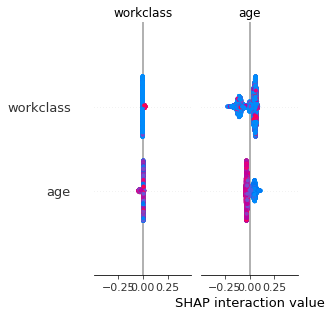

                 0                                                1
0              age       [0.03382226410648493, 0.03382226410648493]
1        workclass     [0.003964892940408369, 0.003964892940408368]
2           fnlwgt  [0.00024947531754395004, 0.0002494753175439498]
3        education      [0.009428719932721787, 0.00942871993272179]
4    education-num     [0.039732613865385374, 0.039732613865385374]
5   marital-status       [0.07993213635861758, 0.07993213635861758]
6       occupation     [0.027588764794919868, 0.027588764794919868]
7     relationship       [0.06102510285903436, 0.06102510285903435]
8             race  [0.00045917947127806653, 0.0004591794712780669]
9              sex       [0.0129975139797284, 0.012997513979728401]
10    capital-gain       [0.03395040683606244, 0.03395040683606244]
11    capital-loss     [0.006376360048468647, 0.006376360048468647]
12  hours-per-week       [0.023049009704641393, 0.0230490097046414]
13  native-country   [0.0006017255608241065, 0.0

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.6165445928479104
Classification report : 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      8158
           1       0.70      0.55      0.62      2588

    accuracy                           0.83     10746
   macro avg       0.78      0.74      0.76     10746
weighted avg       0.83      0.83      0.83     10746

Confusion matrix : 
[[7535  623]
 [1157 1431]]
